# Testing New Hamiltonians

In [1]:
import pennylane as qml
from pennylane import qaoa
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

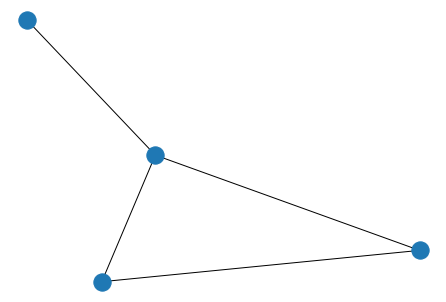

In [2]:
# Defines the graph
edges = [(0, 1), (2, 0), (1, 2), (2, 3)]
graph = nx.Graph(edges)

# Draws the graph
nx.draw(graph)
plt.show()

In [3]:
cost_h, mixer_h = qaoa.max_independent_set(graph, constrained=False)

print("Cost Hamiltonian")
print(cost_h)
print("--------------------")
print("Mixer Hamiltonian")
print(mixer_h)

Cost Hamiltonian
(0.75) [Z0 Z1]
+ (-0.5) [Z0]
+ (-0.5) [Z1]
+ (0.75) [Z0 Z2]
+ (-1.25) [Z2]
+ (0.75) [Z1 Z2]
+ (0.75) [Z2 Z3]
+ (0.25) [Z3]
--------------------
Mixer Hamiltonian
(1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]


In [5]:
# Creates a layer of the QAOA ansatz
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [6]:
# Defines the wires
wires = graph.nodes
depth = 2

# Defines the full QAOA circuit
def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [7]:
# Defines the device
dev = qml.device('qulacs.simulator', wires=wires)

# Defines the cost function
cost_function = qml.VQECost(circuit, cost_h, dev)

In [8]:
# Defines the optimizer, steps, and initial parameters
optimizer = qml.GradientDescentOptimizer()
steps = 40
params = [
    [np.random.randint(-100, 100)/100 for i in range(depth)],
    [np.random.randint(-100, 100)/100 for i in range(depth)]
]

# Optimizes the cost function
for i in range(steps):
    params = optimizer.step(cost_function, params)
    print("Step {} / {}".format(i+1, steps))

# Prints the optimal parameters
print("Optimal Parameters: {}".format(params))

Step 1 / 40
Step 2 / 40
Step 3 / 40
Step 4 / 40
Step 5 / 40
Step 6 / 40
Step 7 / 40
Step 8 / 40
Step 9 / 40
Step 10 / 40
Step 11 / 40
Step 12 / 40
Step 13 / 40
Step 14 / 40
Step 15 / 40
Step 16 / 40
Step 17 / 40
Step 18 / 40
Step 19 / 40
Step 20 / 40
Step 21 / 40
Step 22 / 40
Step 23 / 40
Step 24 / 40
Step 25 / 40
Step 26 / 40
Step 27 / 40
Step 28 / 40
Step 29 / 40
Step 30 / 40
Step 31 / 40
Step 32 / 40
Step 33 / 40
Step 34 / 40
Step 35 / 40
Step 36 / 40
Step 37 / 40
Step 38 / 40
Step 39 / 40
Step 40 / 40
Optimal Parameters: [[0.3891611894097254, 0.37704564154063525], [-0.8977181544310622, -0.5684742841281982]]


In [9]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(params[0], params[1])

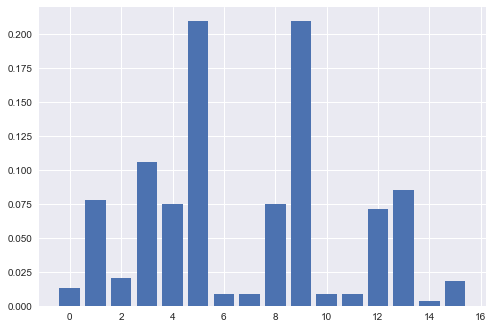

In [10]:
plt.style.use('seaborn')
plt.bar(range(2**len(wires)), probs)
plt.show()

In [17]:
# We then have to reward the edge 00 between nodes 0 and 4

new_cost_h = cost_h + 0.5*qaoa.edge_driver(nx.Graph([(0, 3)]), ['00'])
print(new_cost_h)

(0.75) [Z0 Z1]
+ (-0.625) [Z0]
+ (-0.5) [Z1]
+ (0.75) [Z0 Z2]
+ (-1.25) [Z2]
+ (0.75) [Z1 Z2]
+ (0.75) [Z2 Z3]
+ (0.125) [Z3]
+ (-0.125) [Z0 Z3]


In [18]:
# Creates a layer of the QAOA ansatz
def new_qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, new_cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

# Creates the new circuit
def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(new_qaoa_layer, depth, params[0], params[1])

# Optimizes the circuit

cost_function = qml.VQECost(circuit, new_cost_h, dev)

# Defines the optimizer, steps, and initial parameters
optimizer = qml.GradientDescentOptimizer()
steps = 40
params = [
    [np.random.randint(-100, 100)/100 for i in range(depth)],
    [np.random.randint(-100, 100)/100 for i in range(depth)]
]

# Optimizes the cost function
for i in range(steps):
    params = optimizer.step(cost_function, params)
    print("Step {} / {}".format(i+1, steps))

# Prints the optimal parameters
print("Optimal Parameters: {}".format(params))

Step 1 / 40
Step 2 / 40
Step 3 / 40
Step 4 / 40
Step 5 / 40
Step 6 / 40
Step 7 / 40
Step 8 / 40
Step 9 / 40
Step 10 / 40
Step 11 / 40
Step 12 / 40
Step 13 / 40
Step 14 / 40
Step 15 / 40
Step 16 / 40
Step 17 / 40
Step 18 / 40
Step 19 / 40
Step 20 / 40
Step 21 / 40
Step 22 / 40
Step 23 / 40
Step 24 / 40
Step 25 / 40
Step 26 / 40
Step 27 / 40
Step 28 / 40
Step 29 / 40
Step 30 / 40
Step 31 / 40
Step 32 / 40
Step 33 / 40
Step 34 / 40
Step 35 / 40
Step 36 / 40
Step 37 / 40
Step 38 / 40
Step 39 / 40
Step 40 / 40
Optimal Parameters: [[-0.5866837623303198, -0.9402952118348122], [-0.5400674491099385, -0.8465500520997794]]


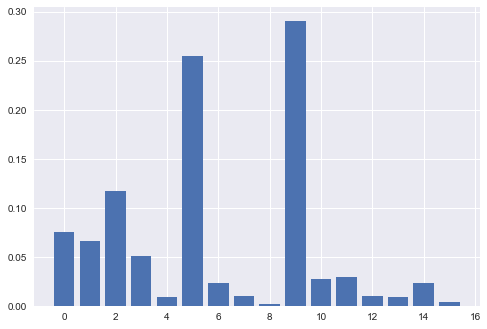

In [20]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(params[0], params[1])

plt.style.use('seaborn')
plt.bar(range(2**len(wires)), probs)
plt.show()